In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

## データ理解

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
train[train.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


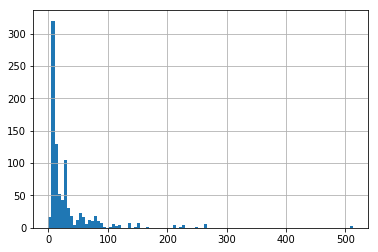

In [8]:
train['Fare'].hist(bins=100)

#### 知見
- 全体：891行
- nullあり
  - Age: 少し
  - Cabin: ほとんど
  - Embarked: 若干(testデータは完全）
- Embarkedがnullの行は異常値として削除してよさそう
- Fareは異常値のような値ああるので注意（変換はしないほうが無難？）

In [9]:
train = train[(~train.Embarked.isnull()) & (train.Fare < 500)]
test = test.fillna({'Fare': test.Fare.mean()})

## 集計① 数値項目

In [10]:
numeric_columns = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']
numeric = train[numeric_columns]

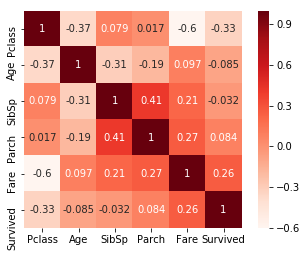

In [11]:
sns.heatmap(numeric.corr(), annot=True, square=True, cmap='Reds')
plt.show()

#### 知見
- Fare, Pclassあたりはかなり効いてきそう


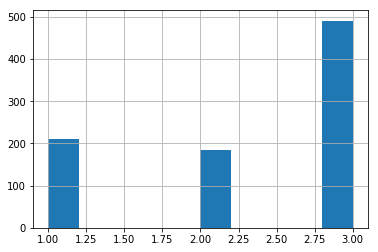

In [12]:
numeric['Pclass'].hist()
plt.show()

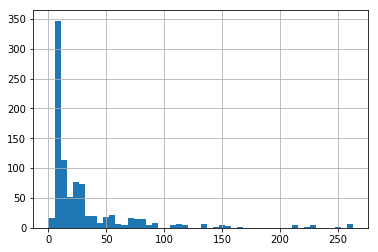

In [13]:
numeric['Fare'].hist(bins=50)
plt.show()

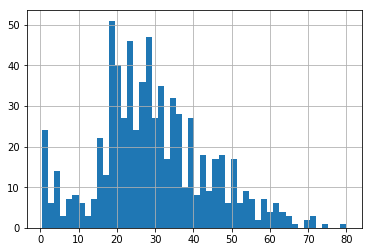

In [14]:
numeric['Age'].hist(bins=50)
plt.show()

#### 知見
- Fare, Ageは正規分布にはなっていないので正規分布化してもいいかも

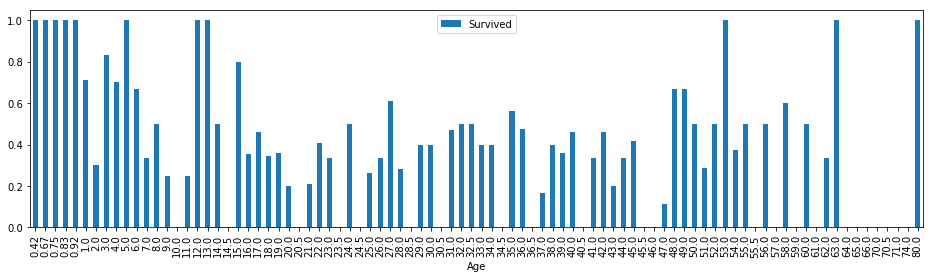

In [15]:
# 年齢別
age = train.loc[:, ['Survived', 'Age']]
g = age.dropna().groupby('Age')
(g.sum() / g.count()).plot(kind='bar', figsize=(16, 4))
plt.show()

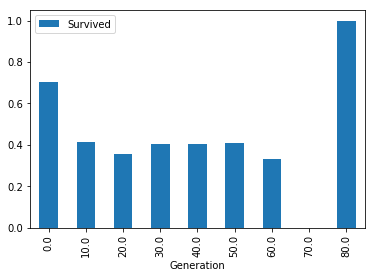

In [16]:
# 年代別
generation = train.loc[:, ['Survived', 'Age']]
generation['Generation'] = round(train['Age'], -1)
g = generation.dropna().drop(columns='Age').groupby('Generation')
(g.sum() / g.count()).plot(kind='bar')
plt.show()

#### 知見
- 5歳以下だと生存率が高い
- 少しは生かせるかな、という程度
  - 欠損もあるので、注意する必要あり

## 集計② Age
- Ageは欠損があるが、特徴があるため欠損埋めをしたい

In [17]:
age = pd.concat([train, test], sort=True, ignore_index=True)[['Age', 'Fare', 'Name', 'Sex']]
age['generation'] = round(age['Age'], -1)

def extract_title(name):
    m = re.search(',\s(.+?)\s.', name)
    return m.group(1)

age['title'] = age['Name'].apply(extract_title)

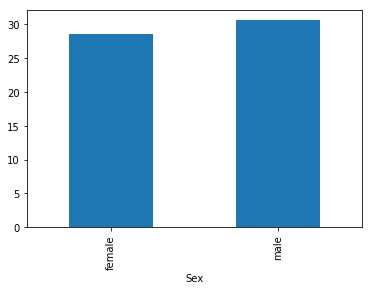

In [18]:
age.groupby('Sex')['Age'].mean().plot(kind='bar')
plt.show()

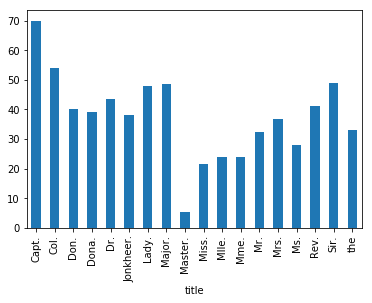

In [19]:
age.groupby('title')['Age'].mean().plot(kind='bar')
plt.show()

#### 知見
- 欠損埋めするならTitleを使ってみよう

## 集計③ Cabin

### cabin_typeごとの乗客数

In [20]:
def get_cabin_type_histgram(df):
    cabins = {}
    for cabin in df.Cabin.values:
        if type(cabin) == str:
            cs = cabin.split(' ')
            for c in cs:
                if c[0] in cabins:
                    cabins[c[0]].append(c[1:])
                else:
                    cabins[c[0]] = [c[1:]]
    pd.DataFrame(sorted([[k, len(v)] for k, v in cabins.items()]), columns=['cabin_type', 'count']).set_index('cabin_type').plot(kind='bar')
    plt.show()

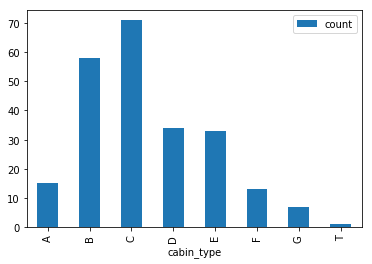

In [21]:
get_cabin_type_histgram(train)

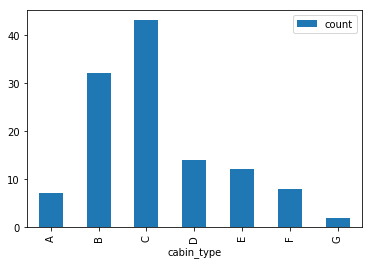

In [22]:
get_cabin_type_histgram(test)

#### 知見
- cabinはA～G, Tがある
- cabin_type別の乗客数は
  - C > B > D > E > F > A > G (>T)

### cabin_typeごとの生存率

In [23]:
cabin_survive_df = []
for s, cabin in train[['Survived', 'Cabin']].values:
    if type(cabin) == str:
        cs = cabin.split(' ')
        for c_type in set([c[0] for c in cs]):
            cabin_survive_df.append([s, c_type])
    else:
        cabin_survive_df.append([s, '-'])
cabin_survive_df = pd.DataFrame(cabin_survive_df, columns=['survived', 'cabin_type'])

In [24]:
g = cabin_survive_df.groupby('cabin_type')
survive_rate = (g.sum() / g.count()).sort_values(by='cabin_type')
survive_rate

,survived
cabin_type,
-,0.298834
A,0.466667
B,0.720930
C,0.593220
D,0.757576
E,0.757576
F,0.615385
G,0.285714
T,0.000000


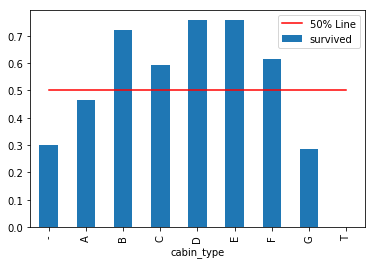

In [25]:
survive_rate.plot(kind='bar')
plt.plot(range(len(survive_rate.index)), [0.5 for i in range(len(survive_rate.index))], color='red', label='50% Line')
plt.legend()
plt.show()

#### 知見
- A, G, - : 生存率が低い
- B, D, E, F: 生存率が高い

### 部屋番号ごとの生存調査

In [26]:
cabin_num_survive_df = []
for s, cabin in train[['Survived', 'Cabin']].values:
    if type(cabin) == str:
        cs = cabin.split(' ')
        for c in cs:
            cabin_num_survive_df.append([s, c[0], c[1:]])
cabin_num_survive_df = pd.DataFrame(cabin_num_survive_df, columns=['survived', 'cabin_type', 'cabin_no'])

In [27]:
cabin_num_survive_df = cabin_num_survive_df[cabin_num_survive_df.cabin_no != ''].astype({'cabin_no': int})

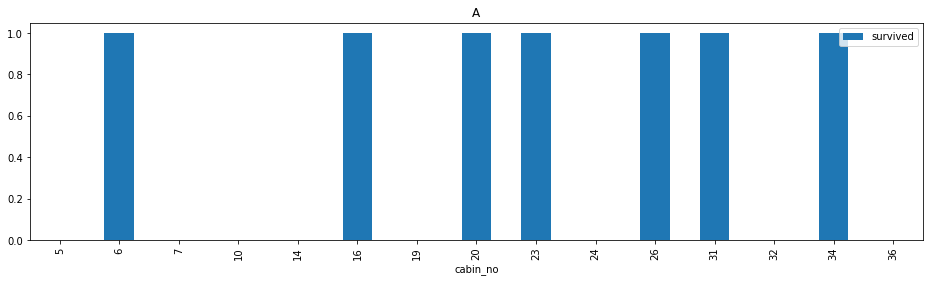

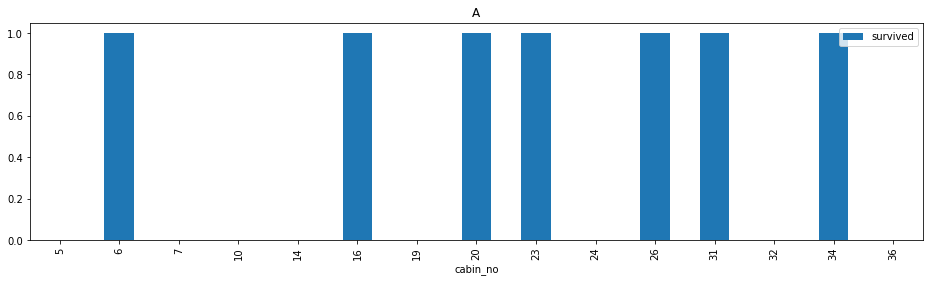

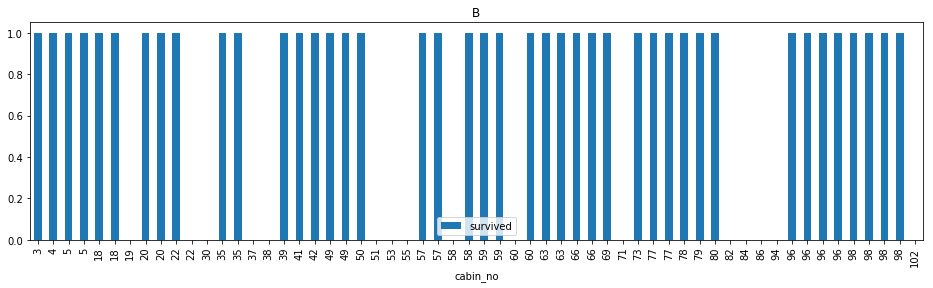

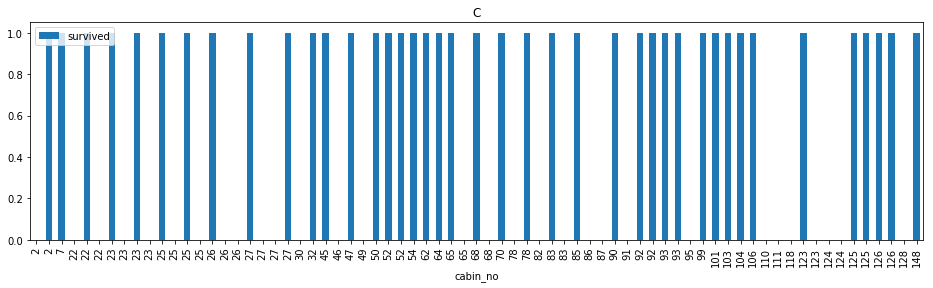

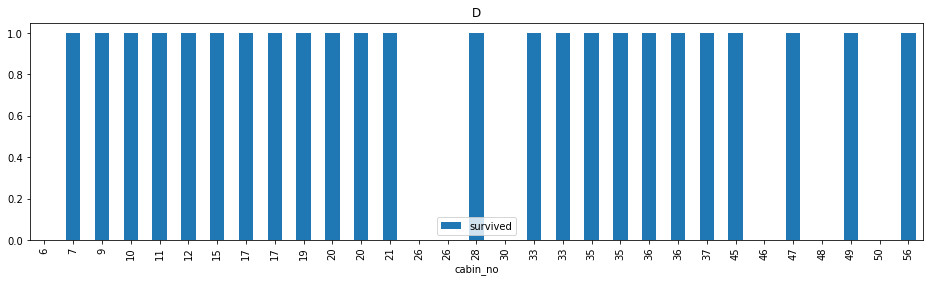

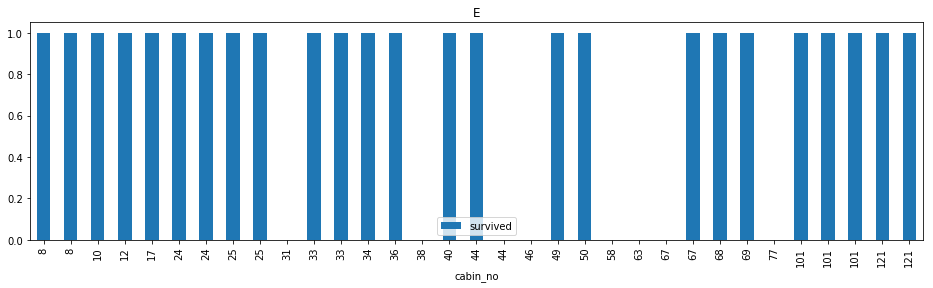

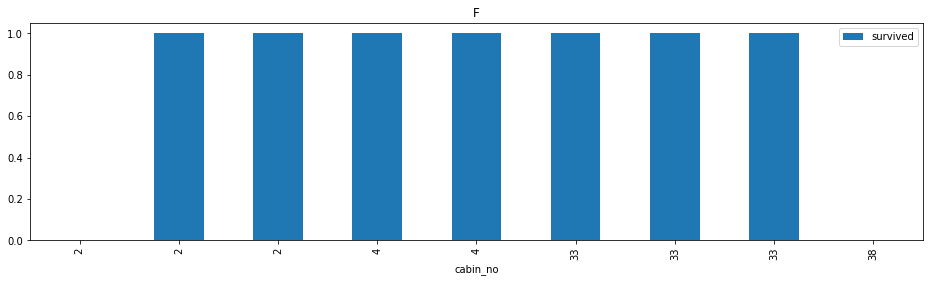

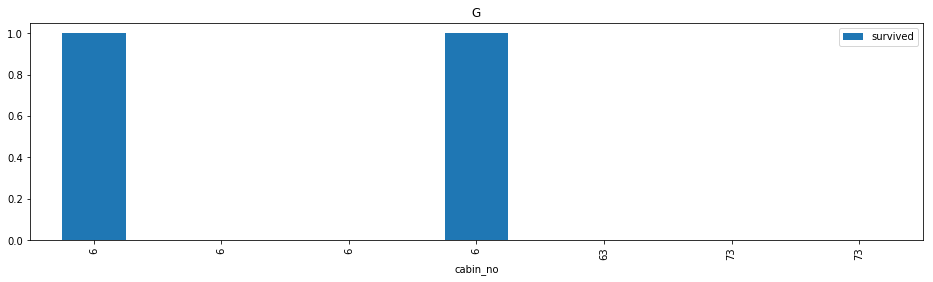

In [28]:
cabin_num_survive_df.groupby('cabin_type').apply(lambda x: x.drop(columns='cabin_type').sort_values('cabin_no').set_index('cabin_no').plot(kind='bar', title=str(x.cabin_type.iloc[0]), figsize=(16,4)))
plt.show()

#### 知見
- 部屋番号で見ると、まばらだが生存しにくいところは固まっている感じである
- cabin_noも特徴量として使ってみる価値はある
- 複数のcabinがある場合
    - 同じcabin_type: 平均のcabin_noを設定
    - 違うcabin_type: 母数の多い順（C > B > D > E > F > A > G (>T)）のcabin_typeを設定
- ただ、Cabin＝NaNの場合のcabin_noの設定ができないため、一旦cabin_noは忘れても。

## 集計④ Sex

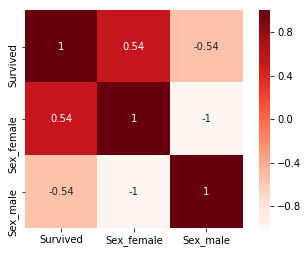

In [29]:
sex = pd.get_dummies(train.loc[:, ['Survived', 'Sex']])
sns.heatmap(sex.corr(), annot=True, square=True, cmap='Reds')
plt.show()

#### 知見
- 性別はかなりの相関がある
  - 使える！

## 集計⑤ Name

In [30]:
train[train.SibSp == 8]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [31]:
train[train.SibSp == 5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
59,60,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9,NaN,S
71,72,0,3,"Goodwin, Miss. Lillian Amy",female,16.0,5,2,CA 2144,46.9,NaN,S
386,387,0,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9,NaN,S
480,481,0,3,"Goodwin, Master. Harold Victor",male,9.0,5,2,CA 2144,46.9,NaN,S
683,684,0,3,"Goodwin, Mr. Charles Edward",male,14.0,5,2,CA 2144,46.9,NaN,S


In [32]:
train[train.SibSp == 4]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
16,17,0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.1250,NaN,Q
50,51,0,3,"Panula, Master. Juha Niilo",male,7.0,4,1,3101295,39.6875,NaN,S
68,69,1,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,NaN,S
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.2750,NaN,S
164,165,0,3,"Panula, Master. Eino Viljami",male,1.0,4,1,3101295,39.6875,NaN,S
171,172,0,3,"Rice, Master. Arthur",male,4.0,4,1,382652,29.1250,NaN,Q
182,183,0,3,"Asplund, Master. Clarence Gustaf Hugo",male,9.0,4,2,347077,31.3875,NaN,S
233,234,1,3,"Asplund, Miss. Lillian Gertrud",female,5.0,4,2,347077,31.3875,NaN,S
261,262,1,3,"Asplund, Master. Edvin Rojj Felix",male,3.0,4,2,347077,31.3875,NaN,S
266,267,0,3,"Panula, Mr. Ernesti Arvid",male,16.0,4,1,3101295,39.6875,NaN,S


#### 知見
- 同じ家族？の生死状況は似通っている
  - 多いほど死んでる
- 家族数と苗字は特徴量に使えそう

## 集計⑥ Ticket

In [33]:
train.Ticket.value_counts()

CA. 2343              7
347082                7
1601                  7
3101295               6
347088                6
CA 2144               6
S.O.C. 14879          5
382652                5
PC 17757              4
347077                4
349909                4
113760                4
LINE                  4
2666                  4
113781                4
19950                 4
4133                  4
17421                 4
W./C. 6608            4
347742                3
C.A. 34651            3
110413                3
SC/Paris 2123         3
13502                 3
239853                3
24160                 3
PC 17582              3
363291                3
29106                 3
C.A. 31921            3
                     ..
312991                1
A/5 3902              1
7552                  1
345763                1
349252                1
113786                1
113051                1
368323                1
PC 17759              1
16988                 1
4136            

In [34]:
def check(x):
    try:
        int(x)
        return False
    except:
        return True

train[train.Ticket.apply(check)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
12,13,0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,NaN,S
30,31,0,1,"Uruchurtu, Don. Manuel E",male,40.0,0,0,PC 17601,27.7208,NaN,C
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
33,34,0,2,"Wheadon, Mr. Edward H",male,66.0,0,0,C.A. 24579,10.5000,NaN,S
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,NaN,C
37,38,0,3,"Cann, Mr. Ernest Charles",male,21.0,0,0,A./5. 2152,8.0500,NaN,S


## 特徴量作成
- 以下の特徴量を使用
  - Age
  - Fare
  - Pclass
  - Sex
  - family
  - title
  - cabin_type
  - cabin_num
  - Embarked
  - first_name
  - ticket_num

In [35]:
all_df = pd.concat([train, test], sort=True, ignore_index=True)

In [37]:
# title
all_df['title'] = all_df['Name'].apply(extract_title)

In [38]:
# age補完
title_mean_age = all_df.groupby('title')['Age'].mean().to_dict()
all_df['Age'].mask(all_df['Age'].isnull(), all_df['title'].apply(lambda x: title_mean_age[x]), inplace=True)

In [39]:
# Family
all_df['family'] = all_df['SibSp'] + all_df['Parch'] + 1 

In [40]:
# first_name

all_df['first_name'] = all_df['Name'].apply(lambda x: x.split(',')[0])

In [41]:
# cabin_type

cabin_type_order = ['C', 'B', 'D', 'E', 'F', 'A', 'G', 'T']

cabin_df = []
for id, cabin in all_df[['PassengerId', 'Cabin']].values:
    cabins = {}
    if cabin == cabin:
        cs = cabin.split(' ')
        cabin_types = set([c[0] for c in cs])
        type = cabin_type_order[min([cabin_type_order.index(cabin_type) for cabin_type in cabin_types])]
        cabin_df.append([id, type, len(cs)])
    else:
        cabin_df.append([id, '-', 0])
cabin_df = pd.DataFrame(cabin_df, columns=['PassengerId', 'cabin_type', 'cabin_num'])

In [42]:
ticket_dict = all_df.Ticket.value_counts().to_dict()
all_df['ticket_num'] = all_df.Ticket.apply(lambda x: ticket_dict[x])

In [43]:
feature_columns = [
    'Age',
    'Fare',
    'Pclass',
    'Sex',
    'family',
    'title',
    'first_name',
    'cabin_type',
    'cabin_num',
    'Embarked',
    'ticket_num',
    'PassengerId',
    'Survived'
]

feature_df = pd.get_dummies(all_df.merge(cabin_df)[feature_columns].fillna({'Survived': -1})).set_index('PassengerId')

In [44]:
train_ = feature_df[feature_df.Survived != -1]
test_ = feature_df[feature_df.Survived == -1].drop(columns='Survived')

## 予測

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [56]:
X_train, X_test, y_train, y_test = train_test_split(train_.drop(columns='Survived'), train_['Survived'], test_size=0.2, random_state=1)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

for model in [SVC(), RandomForestClassifier(n_jobs=-1, random_state=1), GradientBoostingClassifier(n_estimators=10), MLPClassifier(activation='logistic', solver='sgd', max_iter=10**4), LGBMClassifier(), XGBClassifier()]:
    model.fit(X_train, y_train)
    print(model.__class__.__name__, model.score(X_test, y_test))

C:\Users\r82y2\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\r82y2\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\r82y2\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """
C:\Users\r82y2\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC 0.8202247191011236


C:\Users\r82y2\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier 0.8764044943820225
GradientBoostingClassifier 0.8707865168539326
MLPClassifier 0.8202247191011236
LGBMClassifier 0.848314606741573
XGBClassifier 0.8764044943820225


#### 知見
- XGBClassifierを使ってみよう

In [65]:
X_train = train_.drop(columns='Survived')
y_train = train_['Survived']

In [66]:
ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(test_)

C:\Users\r82y2\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\r82y2\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\r82y2\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [67]:
model = GradientBoostingClassifier(n_estimators=10)
model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [68]:
pd.DataFrame(zip(test_.index, model.predict(X_test).astype(int)), columns=['PassengerId', 'Survived']).to_csv('./submission_gb.csv', index=False)

## アンサンブル学習

In [112]:
models = [RandomForestClassifier(n_jobs=-1, random_state=1), GradientBoostingClassifier(n_estimators=10), MLPClassifier(activation='logistic', solver='sgd', max_iter=10**4), LGBMClassifier(), XGBClassifier()]
for i, model in enumerate(models):
    model.fit(X_train, y_train)
    df_ = pd.DataFrame(zip(test_.index, model.predict(X_test).astype(int)), columns=['PassengerId', 'Survived' + model.__class__.__name__])
    if i == 0:
        df = df_
    else:
        df = df.merge(df_, how='left')

C:\Users\r82y2\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [113]:
use_ensemble = ['SurvivedRandomForestClassifier', 'SurvivedGradientBoostingClassifier', 'SurvivedXGBClassifier']

In [114]:
def to_int(x):
    if x:
        return 1
    else:
        return 0

df['Survived'] = (df.drop(columns='PassengerId').sum(axis=1) > len(models) / 2).apply(to_int)

In [110]:
df[['PassengerId', 'Survived']].to_csv('./submission_ensemble.csv', index=False)